# Proyecto Final Visión

## Setup

In [313]:
#Importar las librerías por utilizar
import os
import numpy as np
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import time
from skimage import io
from skimage.filters import threshold_otsu
from skimage.transform import resize, probabilistic_hough_line,hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from skimage.color import rgb2gray,rgb2hsv,hsv2rgb
from skimage.draw import circle_perimeter
from skimage import exposure
from skimage.morphology import disk
from skimage.morphology import (erosion, dilation, opening, closing)
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table
from skimage import data, img_as_float
from skimage import exposure
from scipy import ndimage
import pandas as pd

In [372]:
#Obtener la direccion de las imagenes
path = os.getcwd()

#Lectura de las imagenes de prueba
folder = 'MUESTRAS'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_fotos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    foto = io.imread(file_path)
    lista_fotos.append(foto)

In [334]:
#PARAMETROS

#Ejecutar para informe
INF = False

#Recortar la imagen(%)
Y_MIN = 0.5
Y_MAX = 1
X_MIN = 0
X_MAX = 1

#Escalado
X_PX = 320
Y_PX = 360

#numero de colores incluyendo el fondo
N_COLORS = 5

## Preprocesado

In [133]:
# Escala y Recorta la imagen a 360x320
def edit_image(image):
    y,x = image.shape[:2]
    cropped = image[int(y*Y_MIN):int(y*Y_MAX),int(x*X_MIN):int(x*X_MAX)]
    resized = resize(cropped,(Y_PX,X_PX),preserve_range=True).astype(int)
    return resized

In [134]:
# Convierte la imagen RGBA a RGB
def rgba2rgb( rgba, background=(255,255,255) ):
    row, col, ch = rgba.shape
    if ch == 3:
        return rgba
    assert ch == 4, 'RGBA image has 4 channels.'
    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]
    a = np.asarray( a, dtype='float32' ) / 255.0
    R, G, B = background
    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B
    return np.asarray( rgb, dtype='uint8' )

In [135]:
# Evaluación y Mejora de Saturacion
# https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html
matplotlib.rcParams['font.size'] = 8

def plot_img_and_hist(image, axes, bins=256):
    #Plot an image along with its histogram and cumulative histogram.
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

def stretch_hsv(img_hsv,channel):
    p2, p98 = np.percentile(img_hsv[:,:,channel], (2, 98))
    stretched = exposure.rescale_intensity(img_hsv[:,:,channel], in_range=(p2, p98))
    return stretched

if INF:
    img_org_HSV = rgb2hsv(rgba2rgb(edit_image(lista_fotos[np.random.randint(0,len(lista_fotos))])))
    fig_eval, axs = plt.subplots(1,3,figsize=(22,5))
    fig_eval.suptitle('Evaluación de imagen de entrada')

    axs[0].set_title("Imagen de entrada")
    axs[0].imshow(img_org_HSV[:,:,1],cmap=plt.cm.gray)
    axs[0].set_axis_off()

    # create the histogram
    histogram, bin_edges = np.histogram(img_org_HSV[:,:,1], bins=256, range=(0, 1))
    # Display histogram
    axs[1].set_title("Histograma de Saturación")
    axs[1].set_xlabel("Valor de Saturación")
    axs[1].set_ylabel("Número de pixeles")
    axs[1].set_xlim([0.0, 1])
    axs[1].plot(bin_edges[0:-1], histogram)
    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img_org_HSV[:,:,1], 256)
    axs[2].set_title("Distribución acumulativa")
    axs[2].set_xlabel("Valor de Saturación")
    axs[2].set_ylabel("Acumulado")
    axs[2].set_xlim([0.0, 1])
    axs[2].plot(bins, img_cdf, 'r')
    axs[2].set_yticks([])

    plt.show()

    # Load an example image
    img_sat = img_org_HSV[:,:,1]

    # Contrast stretching
    p2, p98 = np.percentile(img_sat, (2, 98))
    img_rescale_sat = exposure.rescale_intensity(img_sat, in_range=(p2, p98))

    # Equalization
    img_eq_sat = exposure.equalize_hist(img_sat)

    # Adaptive Equalization
    img_adapteq_sat = exposure.equalize_adapthist(img_sat, clip_limit=0.03)

    # Display results
    fig = plt.figure(figsize=(22, 10))
    axes = np.zeros((2, 4), dtype=np.object)
    axes[0, 0] = fig.add_subplot(2, 4, 1)
    for i in range(1, 4):
        axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
    for i in range(0, 4):
        axes[1, i] = fig.add_subplot(2, 4, 5+i)

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_sat, axes[:, 0])
    ax_img.set_title('Low contrast image')

    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_ylabel('Number of pixels')
    ax_hist.set_yticks(np.linspace(0, y_max, 5))

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale_sat, axes[:, 1])
    ax_img.set_title('Stretching de saturación')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq_sat, axes[:, 2])
    ax_img.set_title('Ecualización de Saturación')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq_sat, axes[:, 3])
    ax_img.set_title('Ecualización adaptativa')

    ax_cdf.set_ylabel('Acumulado')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

    # prevent overlap of y-axis labels
    fig.tight_layout()
    plt.show()

In [136]:
# Evaluación y Mejora de Contraste
# https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html
if INF:
    img_org_HSV = rgb2hsv(rgba2rgb(edit_image(lista_fotos[np.random.randint(0,len(lista_fotos))])))
    fig_eval, axs = plt.subplots(1,3,figsize=(22,5))
    fig_eval.suptitle('Evaluación de imagen de entrada')

    axs[0].set_title("Imagen de entrada")
    axs[0].imshow(img_org_HSV[:,:,1],cmap=plt.cm.gray)
    axs[0].set_axis_off()

    # create the histogram
    histogram, bin_edges = np.histogram(img_org_HSV[:,:,2], bins=256, range=(0, 1))
    # Display histogram
    axs[1].set_title("Histograma de Escala de grises")
    axs[1].set_xlabel("Valor de Gradiente")
    axs[1].set_ylabel("Número de pixeles")
    axs[1].set_xlim([0.0, 1])
    axs[1].plot(bin_edges[0:-1], histogram)
    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(img_org_HSV[:,:,2], 256)
    axs[2].set_title("Distribución acumulativa")
    axs[2].set_xlabel("Valor de Gradiente")
    axs[2].set_ylabel("Acumulado")
    axs[2].set_xlim([0.0, 1])
    axs[2].plot(bins, img_cdf, 'r')
    axs[2].set_yticks([])

    plt.show()

    # Load an example image
    img_con = img_org_HSV[:,:,2]

    # Contrast stretching
    p2, p98 = np.percentile(img_con, (2, 98))
    img_rescale_con = exposure.rescale_intensity(img_con, in_range=(p2, p98))

    # Equalization
    img_eq_con = exposure.equalize_hist(img_con)

    # Adaptive Equalization
    img_adapteq_con = exposure.equalize_adapthist(img_con, clip_limit=0.03)

    # Display results
    fig = plt.figure(figsize=(22, 10))
    axes = np.zeros((2, 4), dtype=np.object)
    axes[0, 0] = fig.add_subplot(2, 4, 1)
    for i in range(1, 4):
        axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
    for i in range(0, 4):
        axes[1, i] = fig.add_subplot(2, 4, 5+i)

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_con, axes[:, 0])
    ax_img.set_title('Low contrast image')

    y_min, y_max = ax_hist.get_ylim()
    ax_hist.set_ylabel('Number of pixels')
    ax_hist.set_yticks(np.linspace(0, y_max, 5))

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale_con, axes[:, 1])
    ax_img.set_title('Stretching de contraste')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq_con, axes[:, 2])
    ax_img.set_title('Ecualización de Contraste')

    ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq_con, axes[:, 3])
    ax_img.set_title('Ecualización adaptativa')

    ax_cdf.set_ylabel('Acumulado')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

    # prevent overlap of y-axis labels
    fig.tight_layout()
    plt.show()

In [137]:
# Resultados de Imagen mejorada
if INF:
    index =14#np.random.randint(0,len(lista_fotos))
    print('IMG_' + str(index+1) + '.png')
    img_org_RGB = rgba2rgb(edit_image(lista_fotos[index]))
    img_org_HSV = rgb2hsv(img_org_RGB)
    img_eq_1 = img_org_HSV
    img_eq_1[:,:,1] = stretch_hsv(img_org_HSV,1)
    img_org_HSV = rgb2hsv(img_org_RGB)
    
    img_eq_2 = img_org_HSV
    img_eq_2[:,:,2] = stretch_hsv(img_org_HSV,2)
    img_org_HSV = rgb2hsv(img_org_RGB)

    img_eq_3 = img_org_HSV
    img_eq_3[:,:,1] = stretch_hsv(img_org_HSV,1)
    img_eq_3[:,:,2] = stretch_hsv(img_org_HSV,2)
    img_org_HSV = rgb2hsv(img_org_RGB)

    fig1, axs = plt.subplots(1,4,figsize=(17,6))
    fig1.suptitle('Filtrado de ruido, suavizado y Recuperación de bordes')

    axs[0].set_title("Imagen original")
    axs[0].imshow(hsv2rgb(img_org_HSV))
    axs[0].set_axis_off()

    axs[1].set_title("Imagen mejora saturacion")
    axs[1].imshow(hsv2rgb(img_eq_1))
    axs[1].set_axis_off()

    axs[2].set_title("Imagen mejora contraste")
    axs[2].imshow(hsv2rgb(img_eq_2))
    axs[2].set_axis_off()

    axs[3].set_title("Imagen mejora saturacion y contraste")
    axs[3].imshow(hsv2rgb(img_eq_3))
    axs[3].set_axis_off()

    plt.tight_layout()
    plt.show()

In [319]:
# Quantificacion 4 colores
#https://scikit-learn.org/stable/auto_examples/cluster/plot_color_quantization.html#sphx-glr-auto-examples-cluster-plot-color-quantization-py

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)

def img_to_5_colors(img):
    # Copia de la imagen por cuantificar
    img_5_colors = img

    # Convert to floats instead of the default 8 bits integer coding. Dividing by
    # 255 is important so that plt.imshow behaves works well on float data (need to
    # be in the range [0-1])
    img_5_colors = np.array(img_5_colors, dtype=np.float64)

    # Load Image and transform to a 2D numpy array.
    w, h, d = tuple(img_5_colors.shape)
    assert d == 3
    image_array = np.reshape(img_5_colors, (w * h, d))
    image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
    kmeans = KMeans(n_clusters=N_COLORS, random_state=0).fit(image_array_sample)
    labels = kmeans.predict(image_array)
    colores = kmeans.cluster_centers_
    #coloresh = rgb2hsv(colores)[:,0]
    #coloress = rgb2hsv(colores)[:,1]
    #coloresv = rgb2hsv(colores)[:,2]
    coloresh = colores[:,0]
    coloress = colores[:,1]
    coloresv = colores[:,2]
    #print(coloresh)
    #print(coloress)
    #print(coloresv)
    #pru = recreate_image(colores, labels, w, h)
    #plt.imshow(pru)
    for i in range(N_COLORS):
        if not (0.07 < coloresh[i] < 0.19 and coloress[i] > 0.2 and coloresv[i] > 0.15):
            colores[i] = [0, 0, 0]
        new_img = recreate_image(colores, labels, w, h)
    #plt.imshow(new_img)
    new_img = rgb2hsv(new_img)[:,:,2]
    new_img = new_img > threshold_otsu(new_img)
    footprint = disk(10)
    new_img = closing(new_img,footprint)
    return new_img

In [139]:
# Resultados cuantificada y binarizada
if INF:
    index =11#np.random.randint(0,len(lista_fotos))
    print('IMG_' + str(index+1) + '.png')
    img_org_RGB = rgba2rgb(edit_image(lista_fotos[index]))
    img_org_HSV = rgb2hsv(img_org_RGB)
    img_eq_1 = img_org_HSV
    img_eq_1[:,:,1] = stretch_hsv(img_org_HSV,1)
    img_org_HSV = rgb2hsv(img_org_RGB)
    
    img_eq_2 = img_org_HSV
    img_eq_2[:,:,2] = stretch_hsv(img_org_HSV,2)
    img_org_HSV = rgb2hsv(img_org_RGB)

    img_eq_3 = img_org_HSV
    img_eq_3[:,:,1] = stretch_hsv(img_org_HSV,1)
    img_eq_3[:,:,2] = stretch_hsv(img_org_HSV,2)
    img_org_HSV = rgb2hsv(img_org_RGB)

    quant1 = img_to_5_colors(img_org_HSV)
    quant2 = img_to_5_colors(img_eq_1)
    quant3 = img_to_5_colors(img_eq_2)
    quant4 = img_to_5_colors(img_eq_3)

    fig1, axs = plt.subplots(1,4,figsize=(17,6))
    fig1.suptitle('Filtrado de ruido, suavizado y Recuperación de bordes')

    axs[0].set_title("Imagen original")
    axs[0].imshow(quant1,cmap='gray')
    axs[0].set_axis_off()


    axs[1].set_title("Imagen mejora saturacion")
    axs[1].imshow(quant2,cmap='gray')
    axs[1].set_axis_off()

    axs[2].set_title("Imagen mejora contraste")
    axs[2].imshow(quant3,cmap='gray')
    axs[2].set_axis_off()

    axs[3].set_title("Imagen mejora saturacion y contraste")
    axs[3].imshow(quant4,cmap='gray')
    axs[3].set_axis_off()

    plt.tight_layout()
    plt.show()

In [382]:
def preproc(img):
    resized = edit_image(img)
    img_RGB =rgba2rgb(resized)
    img_HSV =rgb2hsv(img_RGB)
    img_eq = img_HSV
    img_eq[:,:,1] = stretch_hsv(img_HSV,1)
    img_eq[:,:,2] = stretch_hsv(img_HSV,2)
    #plt.imshow(hsv2rgb(img_eq))
    #plt.show()    
    quant = img_to_5_colors(img_HSV)
    return quant

IMG_23.png


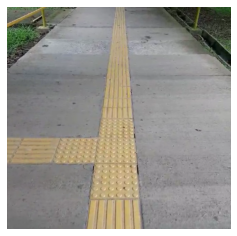

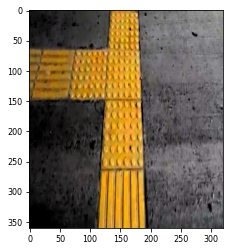

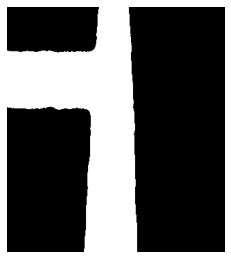

In [363]:
index =np.random.randint(0,len(lista_fotos))
#index = 23
print('IMG_' + str(index+1) + '.png')
img_org_RGB = rgba2rgb(lista_fotos[index])
plt.figure(figsize = (4,4.5))
plt.imshow(img_org_RGB, cmap='gray')
plt.axis('off')
plt.show()
quant = preproc(img_org_RGB)
plt.figure(figsize = (4,4.5))
plt.imshow(quant, cmap='gray')
plt.axis('off')
plt.show()

## Segmentación

1


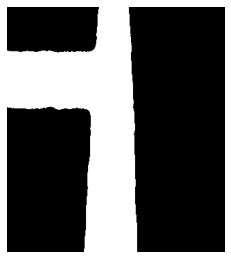

In [364]:
segmented, num_segments = label(quant,return_num = True,connectivity= None)
print(num_segments)
plt.figure(figsize = (4,4.5))
plt.imshow(segmented, cmap='gray')
plt.axis('off')
plt.show()

props = regionprops(segmented)

In [365]:
for i in range(1,num_segments):
    region = segmented == i

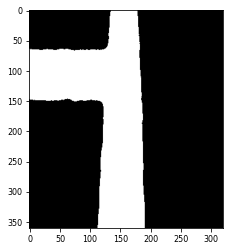

In [366]:
for prop in props:
    if prop.area > 10000 and prop.label != 0:
        region_label = prop.label
        region = (segmented == region_label)*1
plt.imshow(region, cmap = "gray")
plt.show()

In [376]:
def segmentacion(img):
    segmented = label(img, connectivity= None)
    props = regionprops(segmented)
    for prop in props:
        if prop.area > 10000 and prop.label != 0:
            region_label = prop.label
            region = (segmented == region_label)*1
    return region

## Detección de caminos

In [367]:
r_border = region[:,300:320]
l_border = region[:,0:20]
u_border = region[0:40,:] # indica posible interseccion cruz o T
ur_corner = region[0:20,300:320]
ul_corner = region[0:20,0:20]
r_path = np.sum(r_border) > 800 #existe camino der
l_path = np.sum(l_border) > 800 #existe camino izq
u_path = np.sum(u_border) > 500 #posible camino recto
empty_corners = (np.sum(ur_corner) < 100) and (np.sum(ul_corner) < 100) #pocos o nulos pixeles en las esquinas
#es decir la interseccion no queda en el borde para distinguir entre codo e interseccion
print(f"Pixeles en borde: \n derecho: {np.sum(r_border)} \n izquierdo: {np.sum(l_border)} \n superior: {np.sum(u_border)} \n esq der: {np.sum(ur_corner)} \n esq izq: {np.sum(ul_corner)}")
print(f"Pixeles en borde: \n derecho: {r_path} \n izquierdo: {l_path} \n superior: {u_path} \n esquinas vacias: {empty_corners}")

Pixeles en borde: 
 derecho: 0 
 izquierdo: 1671 
 superior: 1882 
 esq der: 0 
 esq izq: 0
Pixeles en borde: 
 derecho: False 
 izquierdo: True 
 superior: True 
 esquinas vacias: True


In [368]:
#Intersecciones
cruz = l_path and r_path and u_path
Te = l_path and r_path and (not u_path)
i_l = l_path and (not r_path) and u_path
i_r = (not l_path) and r_path and u_path
codo_l = l_path and (not r_path) and (not u_path)
codo_r = (not l_path) and r_path and (not u_path)
print(f"Intersecciones: \n cruz: {cruz} \n T: {Te} \n izquierda: {i_l} \n derecha: {i_r} \n codo izq: {codo_l} \n codo der: {codo_r}")

Intersecciones: 
 cruz: False 
 T: False 
 izquierda: True 
 derecha: False 
 codo izq: False 
 codo der: False


In [378]:
def intersecciones(region):
    r_border = region[:,300:320]
    l_border = region[:,0:20]
    u_border = region[0:40,:] # indica posible interseccion cruz o T
    ur_corner = region[0:20,300:320]
    ul_corner = region[0:20,0:20]
    r_path = np.sum(r_border) > 800 #existe camino der
    l_path = np.sum(l_border) > 800 #existe camino izq
    u_path = np.sum(u_border) > 500 #posible camino recto
    empty_corners = (np.sum(ur_corner) < 100) and (np.sum(ul_corner) < 100) #pocos o nulos pixeles en las esquinas
    #es decir la interseccion no queda en el borde para distinguir entre codo e interseccion
    #Intersecciones
    cruz = l_path and r_path and u_path
    Te = l_path and r_path and (not u_path)
    i_l = l_path and (not r_path) and u_path
    i_r = (not l_path) and r_path and u_path
    codo_l = l_path and (not r_path) and (not u_path)
    codo_r = (not l_path) and r_path and (not u_path)
    return (cruz, Te, i_l, i_r, codo_l, codo_r, empty_corners)

In [369]:
instrucciones = ["l","l","r"]
for inst in instrucciones:
    if inst == "l" and empty_corners:
        if cruz or Te or i_l:
            print("Gire a la izq")
            print("Girando")
            time.sleep(5) 
        elif i_r or codo_l:
            print("Continue")
        else:
            print("Continue")
    elif inst == "r" and empty_corners:
        if cruz or Te or i_r:
            print("Gire a la derecha")
            print("Girando")
            time.sleep(5)
        elif i_l or codo_r:
            print("Continue")
        else:
            print("Continue")
    else:
        print("Continue")

Gire a la izq
Girando
Gire a la izq
Girando
Continue


In [380]:
def decision(inst, intersecciones):
    giro = False
    cruz = intersecciones[0]
    Te = intersecciones[1]
    i_l = intersecciones[2]
    i_r = intersecciones[3]
    codo_l = intersecciones[4]
    codo_r = intersecciones[5]
    empty_corners = intersecciones[6]
    if inst == "l" and empty_corners:
        if cruz or Te or i_l:
            print("Gire a la izq \n")
            print("Girando \n")
            time.sleep(5)
            giro = True
        elif i_r or codo_l:
            print("Continue \n")
        else:
            print("Continue \n")
    elif inst == "r" and empty_corners:
        if cruz or Te or i_r:
            print("Gire a la derecha \n")
            print("Girando \n")
            time.sleep(5)
            giro = True
        elif i_l or codo_r:
            print("Continue \n")
        else:
            print("Continue \n")
    else:
        print("Continue \n")
    return giro

## Pruebas parciales

IMG_1.png


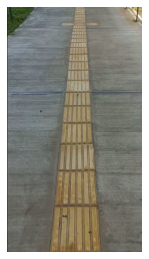

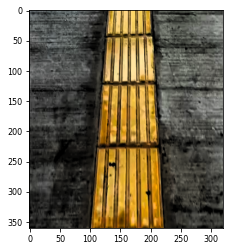

34442


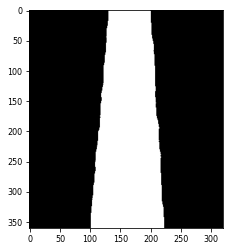

Continue
Continue
Continue
IMG_2.png


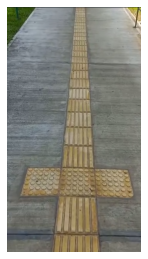

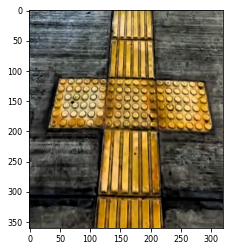

45712


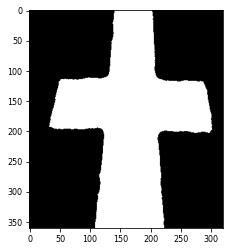

Continue
Continue
Continue
IMG_3.png


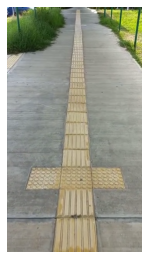

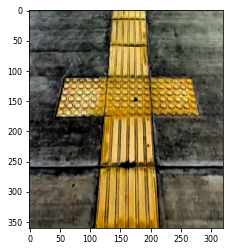

37766


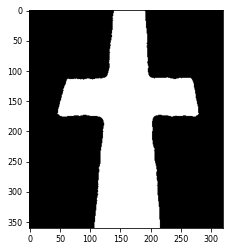

Continue
Continue
Continue
IMG_4.png


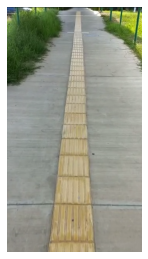

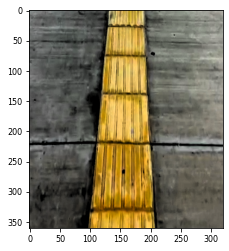

29867


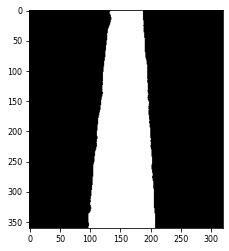

Continue
Continue
Continue
IMG_5.png


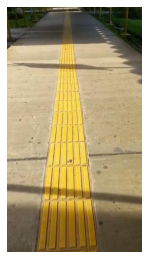

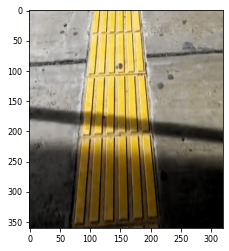

39965


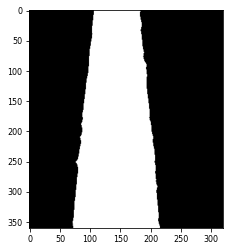

Continue
Continue
Continue
IMG_6.png


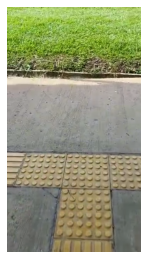

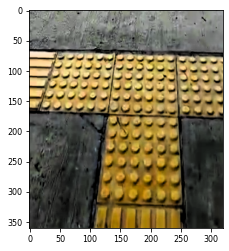

55888


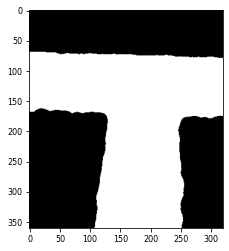

Gire a la izq
Girando
Gire a la izq
Girando
Gire a la derecha
Girando
IMG_7.png


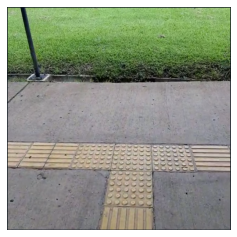

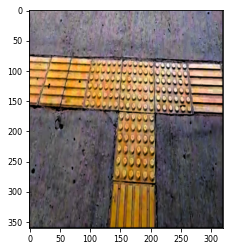

39964


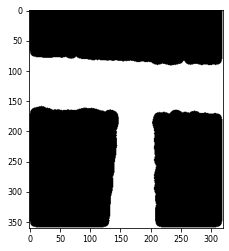

Gire a la izq
Girando
Gire a la izq
Girando
Gire a la derecha
Girando
IMG_8.png


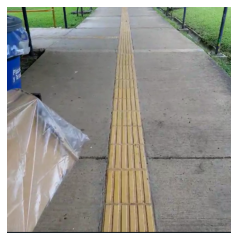

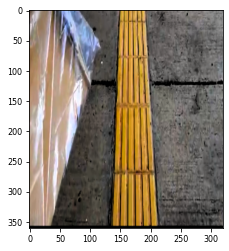

20007


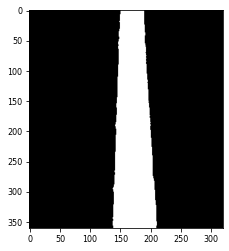

Continue
Continue
Continue
IMG_9.png


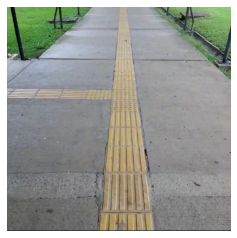

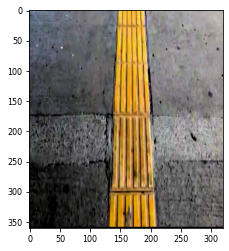

21621


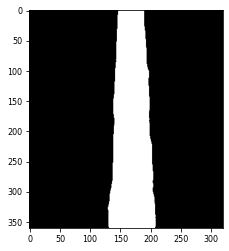

Continue
Continue
Continue
IMG_10.png


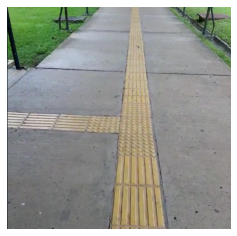

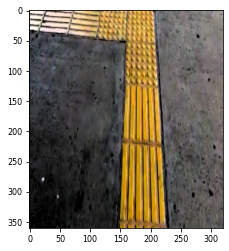

28260


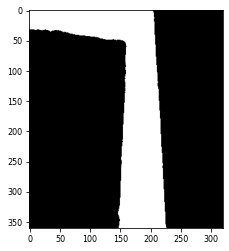

Continue
Continue
Continue
IMG_11.png


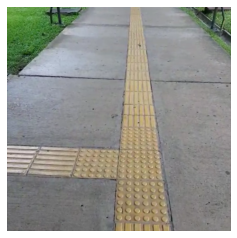

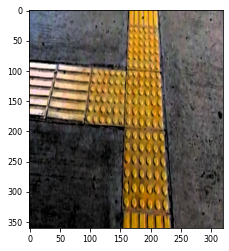

36982


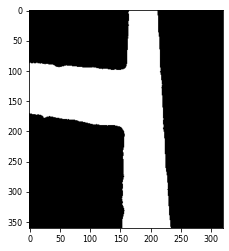

Gire a la izq
Girando
Gire a la izq
Girando
Continue
IMG_12.png


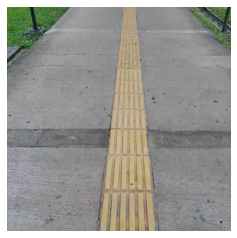

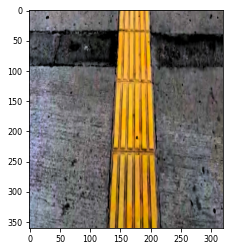

23455


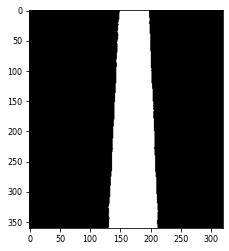

Continue
Continue
Continue
IMG_13.png


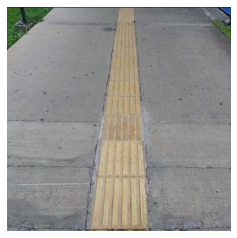

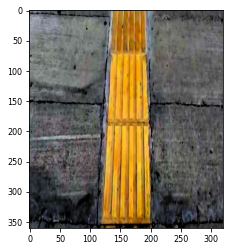

24177


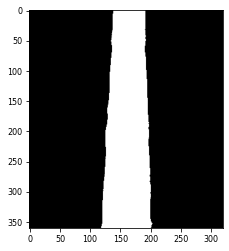

Continue
Continue
Continue
IMG_14.png


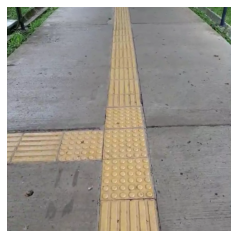

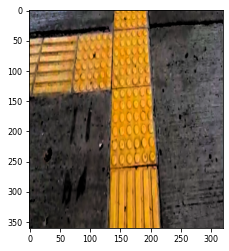

38828


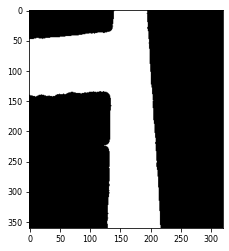

Gire a la izq
Girando
Gire a la izq
Girando
Continue
IMG_15.png


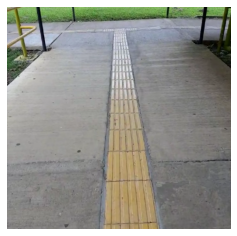

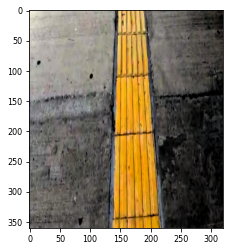

21167


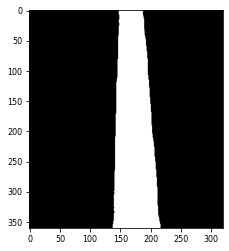

Continue
Continue
Continue
IMG_16.png


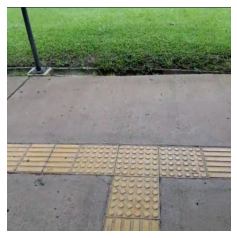

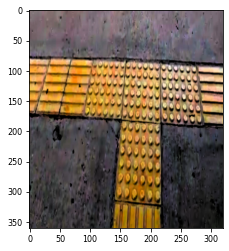

42766


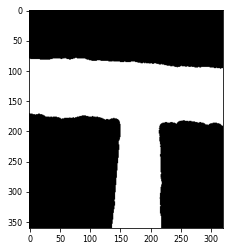

Gire a la izq
Girando
Gire a la izq
Girando
Gire a la derecha
Girando
IMG_17.png


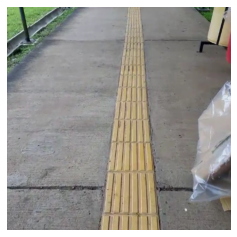

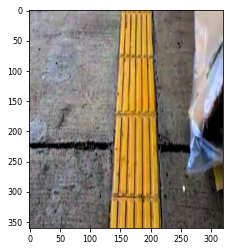

24361


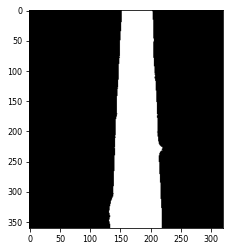

Continue
Continue
Continue
IMG_18.png


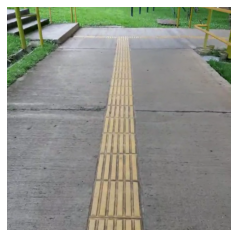

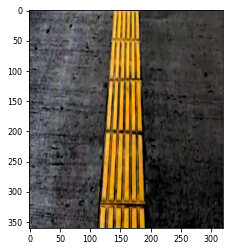

21607


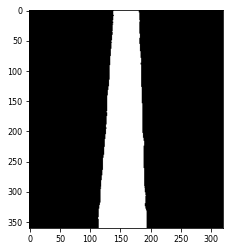

Continue
Continue
Continue
IMG_19.png


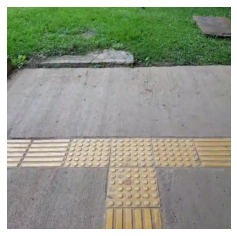

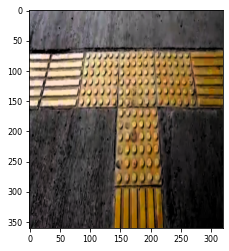

43935


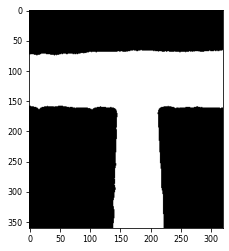

Gire a la izq
Girando
Gire a la izq
Girando
Gire a la derecha
Girando
IMG_20.png


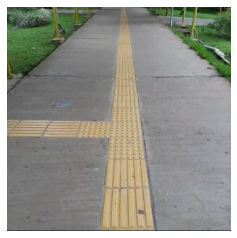

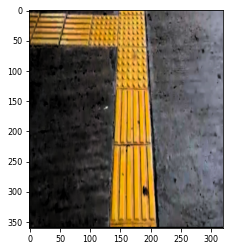

30426


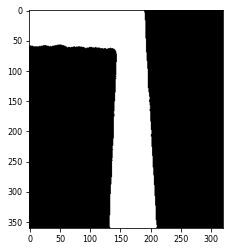

Continue
Continue
Continue
IMG_21.png


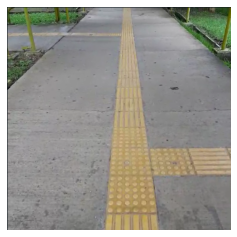

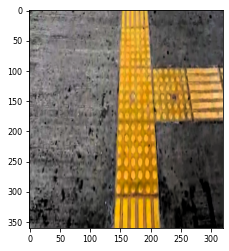

32124


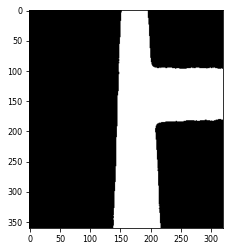

Continue
Continue
Gire a la derecha
Girando
IMG_22.png


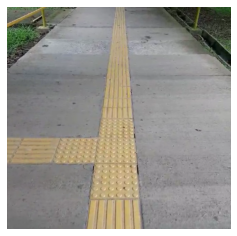

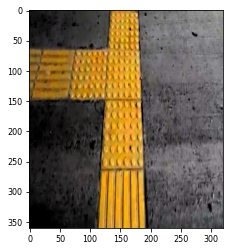

33377


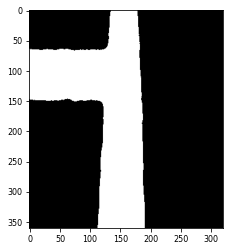

Gire a la izq
Girando
Gire a la izq
Girando
Continue
IMG_23.png


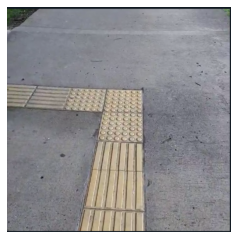

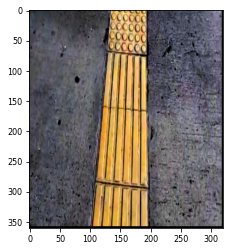

26368


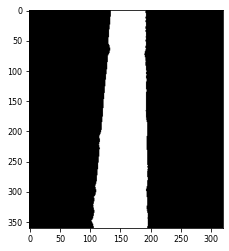

Continue
Continue
Continue


In [375]:
instrucciones = ["l","l","r"]
#index =np.random.randint(0,len(lista_fotos))
#index = 23
for index in range(len(lista_fotos)):
    print('IMG_' + str(index+1) + '.png')
    img_org_RGB = rgba2rgb(lista_fotos[index])
    plt.figure(figsize = (4,4.5))
    plt.imshow(img_org_RGB, cmap='gray')
    plt.axis('off')
    plt.show()

    quant = preproc(img_org_RGB)

    segmented = label(quant, connectivity= None)

    props = regionprops(segmented)
    for prop in props:
        if prop.area > 10000 and prop.label != 0:
            #print(prop.area)
            region_label = prop.label
            region = (segmented == region_label)*1
    plt.imshow(region, cmap = "gray")
    plt.show()


    r_border = region[:,300:320]
    l_border = region[:,0:20]
    u_border = region[0:40,:] # indica posible interseccion cruz o T
    ur_corner = region[0:20,300:320]
    ul_corner = region[0:20,0:20]
    r_path = np.sum(r_border) > 800 #existe camino der
    l_path = np.sum(l_border) > 800 #existe camino izq
    u_path = np.sum(u_border) > 500 #posible camino recto
    empty_corners = (np.sum(ur_corner) < 100) and (np.sum(ul_corner) < 100) #pocos o nulos pixeles en las esquinas
    #es decir la interseccion no queda en el borde para distinguir entre codo e interseccion
    #Intersecciones
    cruz = l_path and r_path and u_path
    Te = l_path and r_path and (not u_path)
    i_l = l_path and (not r_path) and u_path
    i_r = (not l_path) and r_path and u_path
    codo_l = l_path and (not r_path) and (not u_path)
    codo_r = (not l_path) and r_path and (not u_path)


    for inst in instrucciones:
        if inst == "l" and empty_corners:
            if cruz or Te or i_l:
                print("Gire a la izq")
                print("Girando")
                #time.sleep(5) 
            elif i_r or codo_l:
                print("Continue")
            else:
                print("Continue")
        elif inst == "r" and empty_corners:
            if cruz or Te or i_r:
                print("Gire a la derecha")
                print("Girando")
                #time.sleep(5)
            elif i_l or codo_r:
                print("Continue")
            else:
                print("Continue")
        else:
            print("Continue")


IMG_1.png 0


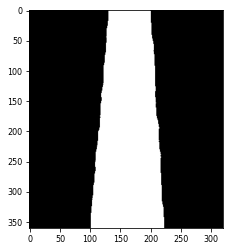

Continue 

IMG_2.png 0


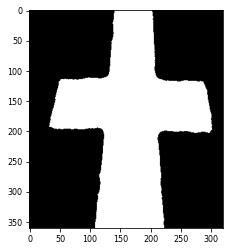

Continue 

IMG_3.png 0


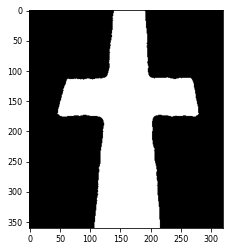

Continue 

IMG_4.png 0


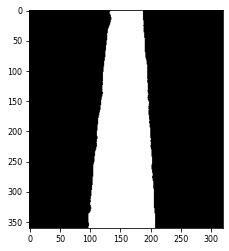

Continue 

IMG_5.png 0


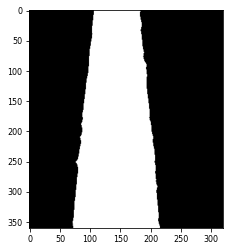

Continue 

IMG_6.png 0


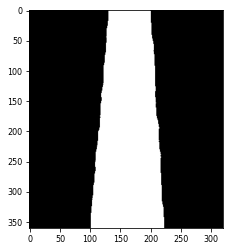

Continue 

IMG_7.png 0


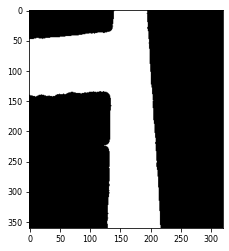

Continue 

IMG_8.png 0


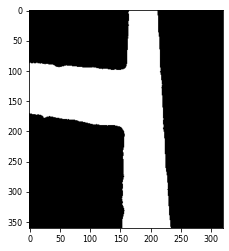

Continue 

IMG_9.png 0


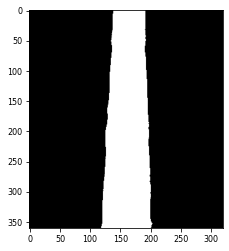

Continue 

IMG_10.png 0


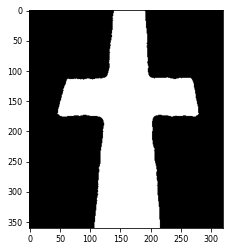

Continue 

IMG_11.png 0


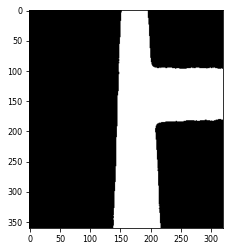

Gire a la derecha 

Girando 

IMG_12.png 1


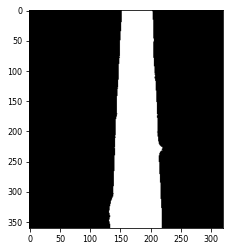

Continue 

IMG_13.png 1


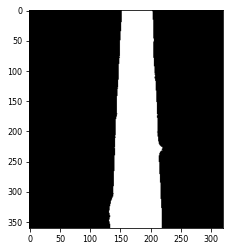

Continue 

IMG_14.png 1


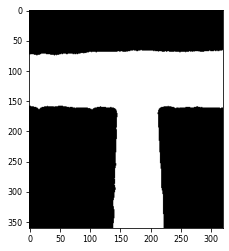

Gire a la izq 

Girando 

IMG_15.png 2


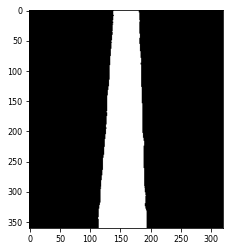

Continue 

IMG_1.png 2


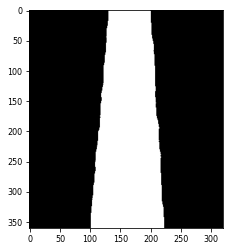

Continue 

IMG_2.png 2


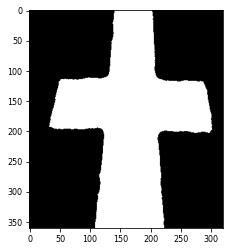

Continue 

IMG_3.png 2


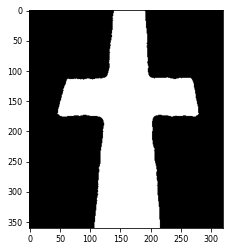

Continue 

IMG_4.png 2


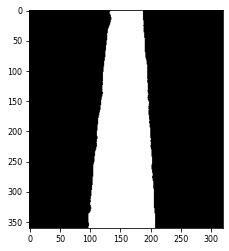

Continue 

IMG_5.png 2


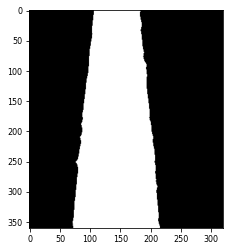

Continue 

IMG_6.png 2


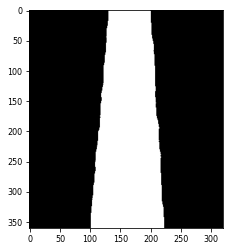

Continue 

IMG_7.png 2


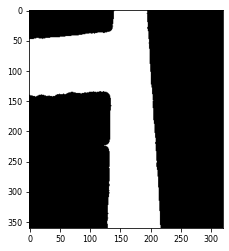

Continue 

IMG_8.png 2


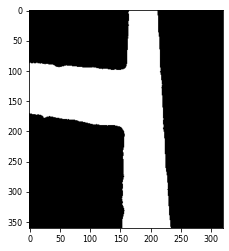

Continue 

IMG_9.png 2


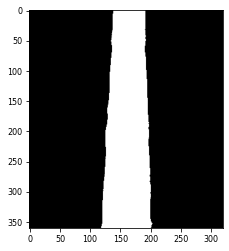

Continue 

IMG_10.png 2


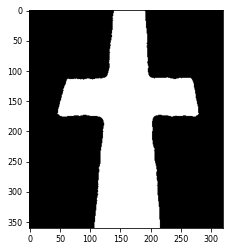

Continue 

IMG_11.png 2


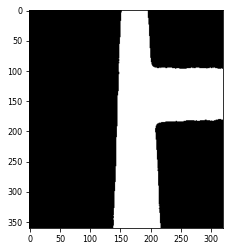

Gire a la derecha 

Girando 

IMG_12.png 3


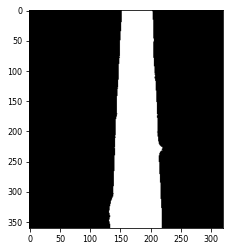

Continue 

IMG_13.png 3


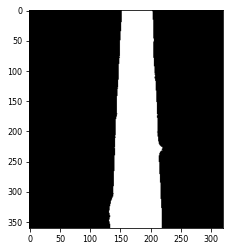

Continue 

IMG_14.png 3


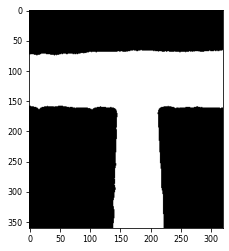

Gire a la derecha 

Girando 

Se ejecutaron todas las instrucciones


In [387]:
folder = 'SECUENCIA'
folder_path = os.path.join(path, folder)
files = os.listdir(folder_path)
lista_fotos = []
for file in files:
    file_path = os.path.join(folder_path, file)
    foto = io.imread(file_path)
    lista_fotos.append(foto)

instrucciones = ["r","l","r","r"]
i = 0
while i < len(instrucciones):
    for index in range(len(lista_fotos)):
        print('IMG_' + str(index+1) + '.png ' + str(i))
        img_org_RGB = rgba2rgb(lista_fotos[index])

        quant = preproc(img_org_RGB)

        region = segmentacion(quant)
        plt.imshow(region, cmap = "gray")
        plt.show()
        intersecs = intersecciones(region)
        giro = decision (instrucciones[i],intersecs)
        if giro:
            i +=1
        if i == len(instrucciones):
            break
print("Se ejecutaron todas las instrucciones")

